In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
import os
import shutil
import numpy as np

import tensorflow as tf
from tensorflow import keras

from pathlib import Path
from IPython.display import display, Audio


DATASET_ROOT = "/content/drive/MyDrive/16000_pcm_speeches"
# The folders in which we will put the audio samples and the noise samples
AUDIO_SUBFOLDER = "audio"
NOISE_SUBFOLDER = "noise"


DATASET_AUDIO_PATH = os.path.join(DATASET_ROOT, AUDIO_SUBFOLDER)
DATASET_NOISE_PATH = os.path.join(DATASET_ROOT, NOISE_SUBFOLDER)

# Percentage of samples to use for validation
VALID_SPLIT = 0.1

# Seed to use when shuffling the dataset and the noise
SHUFFLE_SEED = 43

# The sampling rate to use.
# This is the one used in all the audio samples.
# We will resample all the noise to this sampling rate.
# This will also be the output size of the audio wave samples
# (since all samples are of 1 second long)
SAMPLING_RATE = 16000

# The factor to multiply the noise with according to:
#   noisy_sample = sample + noise * prop * scale
#      where prop = sample_amplitude / noise_amplitude
SCALE = 0.5

BATCH_SIZE = 128
EPOCHS = 24


In [ ]:
# If folder `audio`, does not exist, create it, otherwise do nothing
if os.path.exists(DATASET_AUDIO_PATH) is False:
    os.makedirs(DATASET_AUDIO_PATH)

# If folder `noise`, does not exist, create it, otherwise do nothing
if os.path.exists(DATASET_NOISE_PATH) is False:
    os.makedirs(DATASET_NOISE_PATH)

for folder in os.listdir(DATASET_ROOT):
    if os.path.isdir(os.path.join(DATASET_ROOT, folder)):
        if folder in [AUDIO_SUBFOLDER, NOISE_SUBFOLDER]:
            # If folder is `audio` or `noise`, do nothing
            continue
        elif folder in ["other", "_background_noise_"]:
            # If folder is one of the folders that contains noise samples,
            # move it to the `noise` folder
            shutil.move(
                os.path.join(DATASET_ROOT, folder),
                os.path.join(DATASET_NOISE_PATH, folder),
            )
        else:
            # Otherwise, it should be a speaker folder, then move it to
            # `audio` folder
            shutil.move(
                os.path.join(DATASET_ROOT, folder),
                os.path.join(DATASET_AUDIO_PATH, folder),
            )

In [ ]:
# Get the list of all noise files
noise_paths = []
for subdir in os.listdir(DATASET_NOISE_PATH):
    subdir_path = Path(DATASET_NOISE_PATH) / subdir
    if os.path.isdir(subdir_path):
        noise_paths += [
            os.path.join(subdir_path, filepath)
            for filepath in os.listdir(subdir_path)
            if filepath.endswith(".wav")
        ]

print(
    "Found {} files belonging to {} directories".format(
        len(noise_paths), len(os.listdir(DATASET_NOISE_PATH))
    )
)

Found 6 files belonging to 2 directories


In [ ]:
command = (
    "for dir in `ls -1 " + DATASET_NOISE_PATH + "`; do "
    "for file in `ls -1 " + DATASET_NOISE_PATH + "/$dir/*.wav`; do "
    "sample_rate=`ffprobe -hide_banner -loglevel panic -show_streams "
    "$file | grep sample_rate | cut -f2 -d=`; "
    "if [ $sample_rate -ne 16000 ]; then "
    "ffmpeg -hide_banner -loglevel panic -y "
    "-i $file -ar 16000 temp.wav; "
    "mv temp.wav $file; "
    "fi; done; done"
)
os.system(command)

# Split noise into chunks of 16,000 steps each
def load_noise_sample(path):
    sample, sampling_rate = tf.audio.decode_wav(
        tf.io.read_file(path), desired_channels=1
    )
    if sampling_rate == SAMPLING_RATE:
        # Number of slices of 16000 each that can be generated from the noise sample
        slices = int(sample.shape[0] / SAMPLING_RATE)
        sample = tf.split(sample[: slices * SAMPLING_RATE], slices)
        return sample
    else:
        print("Sampling rate for {} is incorrect. Ignoring it".format(path))
        return None

noises = []
for path in noise_paths:
    sample = load_noise_sample(path)
    if sample:
        noises.extend(sample)
noises = tf.stack(noises)

print(
    "{} noise files were split into {} noise samples where each is {} sec. long".format(
        len(noise_paths), noises.shape[0], noises.shape[1] // SAMPLING_RATE
    )
)

6 noise files were split into 354 noise samples where each is 1 sec. long


In [ ]:

def paths_and_labels_to_dataset(audio_paths, labels):
    """Constructs a dataset of audios and labels."""
    path_ds = tf.data.Dataset.from_tensor_slices(audio_paths)
    audio_ds = path_ds.map(lambda x: path_to_audio(x))
    label_ds = tf.data.Dataset.from_tensor_slices(labels)
    return tf.data.Dataset.zip((audio_ds, label_ds))


def path_to_audio(path):
    """Reads and decodes an audio file."""
    audio = tf.io.read_file(path)
    audio, _ = tf.audio.decode_wav(audio, 1, SAMPLING_RATE)
    return audio


def add_noise(audio, noises=None, scale=0.5):
    if noises is not None:
        # Create a random tensor of the same size as audio ranging from
        # 0 to the number of noise stream samples that we have.
        tf_rnd = tf.random.uniform(
            (tf.shape(audio)[0],), 0, noises.shape[0], dtype=tf.int32
        )
        noise = tf.gather(noises, tf_rnd, axis=0)

        # Get the amplitude proportion between the audio and the noise
        prop = tf.math.reduce_max(audio, axis=1) / tf.math.reduce_max(noise, axis=1)
        prop = tf.repeat(tf.expand_dims(prop, axis=1), tf.shape(audio)[1], axis=1)

        # Adding the rescaled noise to audio
        audio = audio + noise * prop * scale

    return audio


def audio_to_fft(audio):
    # Since tf.signal.fft applies FFT on the innermost dimension,
    # we need to squeeze the dimensions and then expand them again
    # after FFT
    audio = tf.squeeze(audio, axis=-1)
    fft = tf.signal.fft(
        tf.cast(tf.complex(real=audio, imag=tf.zeros_like(audio)), tf.complex64)
    )
    fft = tf.expand_dims(fft, axis=-1)

    # Return the absolute value of the first half of the FFT
    # which represents the positive frequencies
    return tf.math.abs(fft[:, : (audio.shape[1] // 2), :])


# Get the list of audio file paths along with their corresponding labels

class_names = os.listdir(DATASET_AUDIO_PATH)
print("Our class names: {}".format(class_names,))

audio_paths = []
labels = []
for label, name in enumerate(class_names):
    print("Processing speaker {}".format(name,))
    dir_path = Path(DATASET_AUDIO_PATH) / name
    speaker_sample_paths = [
        os.path.join(dir_path, filepath)
        for filepath in os.listdir(dir_path)
        if filepath.endswith(".wav")
    ]
    audio_paths += speaker_sample_paths
    labels += [label] * len(speaker_sample_paths)

print(
    "Found {} files belonging to {} classes.".format(len(audio_paths), len(class_names))
)

# Shuffle
rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(audio_paths)
rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(labels)

# Split into training and validation
num_val_samples = int(VALID_SPLIT * len(audio_paths))
print("Using {} files for training.".format(len(audio_paths) - num_val_samples))
train_audio_paths = audio_paths[:-num_val_samples]
train_labels = labels[:-num_val_samples]

print("Using {} files for validation.".format(num_val_samples))
valid_audio_paths = audio_paths[-num_val_samples:]
valid_labels = labels[-num_val_samples:]

# Create 2 datasets, one for training and the other for validation
train_ds = paths_and_labels_to_dataset(train_audio_paths, train_labels)
train_ds = train_ds.shuffle(buffer_size=BATCH_SIZE * 8, seed=SHUFFLE_SEED).batch(
    BATCH_SIZE
)

valid_ds = paths_and_labels_to_dataset(valid_audio_paths, valid_labels)
valid_ds = valid_ds.shuffle(buffer_size=32 * 8, seed=SHUFFLE_SEED).batch(32)


# Add noise to the training set
train_ds = train_ds.map(
    lambda x, y: (add_noise(x, noises, scale=SCALE), y),
    num_parallel_calls=tf.data.AUTOTUNE,
)

# Transform audio wave to the frequency domain using `audio_to_fft`
train_ds = train_ds.map(
    lambda x, y: (audio_to_fft(x), y), num_parallel_calls=tf.data.AUTOTUNE
)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

valid_ds = valid_ds.map(
    lambda x, y: (audio_to_fft(x), y), num_parallel_calls=tf.data.AUTOTUNE
)
valid_ds = valid_ds.prefetch(tf.data.AUTOTUNE)

Our class names: ['Jens_Stoltenberg', 'Nelson_Mandela', 'Julia_Gillard', 'Magaret_Tarcher', 'Benjamin_Netanyau']
Processing speaker Jens_Stoltenberg
Processing speaker Nelson_Mandela
Processing speaker Julia_Gillard
Processing speaker Magaret_Tarcher
Processing speaker Benjamin_Netanyau
Found 7501 files belonging to 5 classes.
Using 6751 files for training.
Using 750 files for validation.


In [ ]:
from tensorflow.keras.models import load_model

model = load_model("/content/drive/MyDrive/best_model.keras")  # Ensure that the model file exists and is compatible

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the EarlyStopping callback
earlystopping_cb = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

# Define the ModelCheckpoint callback
mdlcheckpoint_cb = ModelCheckpoint(
    filepath='best_model.keras',  # Path to save the model
    monitor='val_loss',           # Monitor validation loss
    save_best_only=True           # Save only the best model
)

history = model.fit(
    train_ds,
    epochs=5,
    validation_data=valid_ds,
    callbacks=[earlystopping_cb, mdlcheckpoint_cb],  # Pass the instantiated callbacks
)

Epoch 1/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 891s 14s/step - accuracy: 0.9474 - loss: 0.1364 - val_accuracy: 0.9693 - val_loss: 0.1026
Epoch 2/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 513s 9s/step - accuracy: 0.9594 - loss: 0.1152 - val_accuracy: 0.9640 - val_loss: 0.1260
Epoch 3/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 476s 9s/step - accuracy: 0.9576 - loss: 0.1135 - val_accuracy: 0.9827 - val_loss: 0.0781
Epoch 4/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 457s 9s/step - accuracy: 0.9657 - loss: 0.0937 - val_accuracy: 0.9813 - val_loss: 0.0772
Epoch 5/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 497s 8s/step - accuracy: 0.9629 - loss: 0.0992 - val_accuracy: 0.9813 - val_loss: 0.0630


In [ ]:
print(model.evaluate(valid_ds))

24/24 ━━━━━━━━━━━━━━━━━━━━ 15s 576ms/step - accuracy: 0.9861 - loss: 0.0576
[0.06302730739116669, 0.981333315372467]


In [ ]:
def paths_to_dataset(audio_paths):
    path_ds = tf.data.Dataset.from_tensor_slices(audio_paths)
    return tf.data.Dataset.zip((path_ds))

def predict(path, labels):
    test = paths_and_labels_to_dataset(path, labels)


    test = test.shuffle(buffer_size=BATCH_SIZE * 8, seed=SHUFFLE_SEED).batch(
    BATCH_SIZE
    )
    test = test.prefetch(tf.data.experimental.AUTOTUNE)


    test = test.map(lambda x, y: (add_noise(x, noises, scale=SCALE), y))

    for audios, labels in test.take(1):
        ffts = audio_to_fft(audios)
        y_pred = model.predict(ffts)
        rnd = np.random.randint(0, 1, 1)
        audios = audios.numpy()[rnd, :]
        labels = labels.numpy()[rnd]
        y_pred = np.argmax(y_pred, axis=-1)[rnd]

    for index in range(1):
            print(
            "Speaker:\33{} {}\33[0m\tPredicted:\33{} {}\33[0m".format(
            "[92m",y_pred[index],
                "[92m", y_pred[index]
                )
            )

            print("Speaker Predicted:",class_names[y_pred[index]])

In [ ]:
SAMPLES_TO_DISPLAY = 10

test_ds = paths_and_labels_to_dataset(valid_audio_paths, valid_labels)
test_ds = test_ds.shuffle(buffer_size=BATCH_SIZE * 8, seed=SHUFFLE_SEED).batch(
    BATCH_SIZE
)

test_ds = test_ds.map(lambda x, y: (add_noise(x, noises, scale=SCALE), y))

for audios, labels in test_ds.take(1):
    # Get the signal FFT
    ffts = audio_to_fft(audios)
    # Predict
    y_pred = model.predict(ffts)
    # Take random samples
    rnd = np.random.randint(0, BATCH_SIZE, SAMPLES_TO_DISPLAY)
    audios = audios.numpy()[rnd, :, :]
    labels = labels.numpy()[rnd]
    y_pred = np.argmax(y_pred, axis=-1)[rnd]

    for index in range(SAMPLES_TO_DISPLAY):
        # For every sample, print the true and predicted label
        # as well as run the voice with the noise
        print(
            "Speaker:\33{} {}\33[0m\tPredicted:\33{} {}\33[0m".format(
                "[92m" if labels[index] == y_pred[index] else "[91m",
                class_names[labels[index]],
                "[92m" if labels[index] == y_pred[index] else "[91m",
                class_names[y_pred[index]],
            )
        )
        display(Audio(audios[index, :, :].squeeze(), rate=SAMPLING_RATE))

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 443ms/step
Speaker: Magaret_Tarcher	Predicted: Magaret_Tarcher


Speaker: Magaret_Tarcher	Predicted: Magaret_Tarcher


Speaker: Magaret_Tarcher	Predicted: Magaret_Tarcher


Speaker: Julia_Gillard	Predicted: Julia_Gillard


Speaker: Benjamin_Netanyau	Predicted: Benjamin_Netanyau


Speaker: Jens_Stoltenberg	Predicted: Jens_Stoltenberg


Speaker: Julia_Gillard	Predicted: Julia_Gillard


Speaker: Julia_Gillard	Predicted: Julia_Gillard


Speaker: Benjamin_Netanyau	Predicted: Benjamin_Netanyau


Speaker: Julia_Gillard	Predicted: Julia_Gillard


In [ ]:
import tensorflow as tf
import numpy as np
import soundfile as sf  # Library to load .wav files

def load_audio(path):
    """Load an audio file and return it as a tensor."""
    audio_data, _ = sf.read(path.numpy())  # Convert tensor path to string and load the file
    audio_data = tf.convert_to_tensor(audio_data, dtype=tf.float32)  # Convert to tensor
    return tf.expand_dims(audio_data, axis=-1)  # Add an extra dimension for the channel

def load_audio_wrapper(path):
    """A wrapper to use load_audio with tf.py_function."""
    audio = tf.py_function(load_audio, [path], tf.float32)  # Use tf.py_function for non-TensorFlow ops
    return audio

def paths_to_dataset(audio_paths):
    """Convert a list of audio paths into a dataset of loaded audio data."""
    path_ds = tf.data.Dataset.from_tensor_slices(audio_paths)
    audio_ds = path_ds.map(lambda path: load_audio_wrapper(path))  # Use the wrapper function
    return audio_ds



In [ ]:
import librosa
import soundfile as sf
import numpy as np

def load_and_pad_audio(file_path, target_length=16000, sr=16000):
    # Load audio file with librosa
    audio_data, sample_rate = librosa.load(file_path, sr=sr)

    # If the audio is shorter than the target length, pad with zeros
    if len(audio_data) < target_length:
        padding = target_length - len(audio_data)
        audio_data = np.pad(audio_data, (0, padding), 'constant')

    # If the audio is longer, truncate it
    elif len(audio_data) > target_length:
        audio_data = audio_data[:target_length]

    return audio_data, sample_rate

# Load, pad, and save the audio
audio_data, sample_rate = load_and_pad_audio("/content/drive/MyDrive/pink_noise.wav")
sf.write("/content/pink_noise_padded.wav", audio_data, sample_rate)


In [ ]:
def predict(audio_path, labels, threshold=0.94):
    """Process and predict the speaker."""
    test = paths_to_dataset([audio_path])  # Load the audio

    test = test.batch(1)  # Process one audio at a time
    test = test.map(lambda x: add_noise(x, noises, scale=SCALE))  # Add noise if needed
    test = test.prefetch(tf.data.experimental.AUTOTUNE)

    for audios in test.take(1):
        ffts = audio_to_fft(audios)  # Convert audio to FFT
        y_pred = model.predict(ffts)  # Make predictions
        y_pred_class = np.argmax(y_pred, axis=-1)[0]  # Get the predicted class
        y_pred_confidence = np.max(y_pred)  # Get the confidence score

    # Check if the prediction confidence is above the threshold
    if y_pred_confidence >= threshold:
        return class_names[y_pred_class], y_pred_confidence
    else:
        return "Unknown", y_pred_confidence


In [ ]:
def authenticate_user(audio_path, known_speakers, threshold=0.94):
    """
    Authenticate the user based on their voice.

    Parameters:
    audio_path (str): Path to the audio file to authenticate.
    known_speakers (list): List of known speaker names (the 5 trained individuals).
    threshold (float): Confidence threshold for authentication.

    Returns:
    str: "Authenticated" if the speaker is recognized, otherwise "Access Denied".
    """
    predicted_speaker, confidence = predict(audio_path, known_speakers, threshold)

    # Check if the predicted speaker is in the list of known speakers
    if predicted_speaker in known_speakers:
        return f"Authenticated: {predicted_speaker} with confidence {confidence:.2f}"
    else:
        return f"Access Denied: Confidence {confidence:.2f}"


In [ ]:
trained_speakers = ["Benjamin_Netanyau", "Jens_Stoltenberg", "Julia_Gillard", "Margaret_Thatcher", "Nelson_Mandela","unknown"]

# Example usage
audio_file_path = "/content/pink_noise_padded.wav"
result = authenticate_user(audio_file_path, trained_speakers)
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step
Access Denied: Confidence 0.75


In [ ]:
audio_file_path = "/content/drive/MyDrive/16000_pcm_speeches/audio/Jens_Stoltenberg/10.wav"
result = authenticate_user(audio_file_path, trained_speakers)
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Authenticated: Jens_Stoltenberg with confidence 1.00


24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 613ms/step
[[30 28 31 33 33]
 [33 32 22 26 28]
 [25 32 40 27 28]
 [34 28 21 31 33]
 [33 23 38 29 32]]



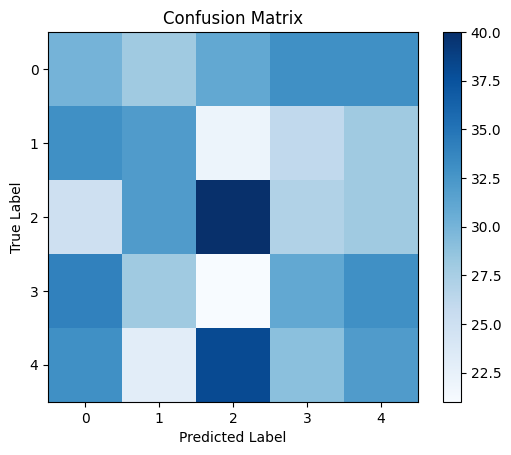

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

y_pred = model.predict(valid_ds)

# Get the true labels
y_true = np.array(valid_labels)

# Generate confusion matrix
cm = confusion_matrix(y_true, np.argmax(y_pred, axis=1))

# Print the confusion matrix
print(cm)
print("")
# Plot the confusion matrix
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
import tensorflow as tf
import numpy as np
import soundfile as sf  # To load .wav files
import librosa

In [ ]:
def load_and_pad_audio(file_path, target_length=16000, sr=16000):
    # Load audio file with librosa
    audio_data, sample_rate = librosa.load(file_path, sr=sr)

    # If the audio is shorter than the target length, pad with zeros
    if len(audio_data) < target_length:
        padding = target_length - len(audio_data)
        audio_data = np.pad(audio_data, (0, padding), 'constant')

    # If the audio is longer, truncate it
    elif len(audio_data) > target_length:
        audio_data = audio_data[:target_length]

    return audio_data, sample_rate


In [ ]:
import tensorflow_hub as hub

# Load the pre-trained model
keyword_spotting_model = hub.load("https://tfhub.dev/google/yamnet/1")

# Use this model in your code
print("Model loaded successfully!")


Model loaded successfully!


In [ ]:
# Example keyword list
keywords = ['login', 'access', 'grant']

# Load a pre-trained keyword spotting model
# Ensure you have trained or downloaded a suitable model for keyword detection
keyword_model = keyword_spotting_model

def preprocess_audio_for_yamnet(audio_path):
    """Load and preprocess audio for YAMNet."""
    # Load audio file
    audio_data, _ = librosa.load(audio_path, sr=16000, mono=True)
    # Convert to tensor
    audio_tensor = tf.convert_to_tensor(audio_data, dtype=tf.float32)
    return audio_tensor

def predict_keywords(audio_path, threshold=0.5):
    """Predict keywords in the given audio file using the YAMNet model."""
    # Preprocess the audio
    audio_data = preprocess_audio_for_yamnet(audio_path)

    # Use the YAMNet model to get predictions
    scores, embeddings, spectrogram = keyword_model(audio_data)

    # Find which keywords were recognized
    recognized_keywords = []
    for idx, score in enumerate(scores[0]):
        if score > threshold:
            recognized_keywords.append((idx, score))

    return recognized_keywords


In [ ]:
def authenticate_user_with_keywords(audio_path, known_speakers, required_keywords, voice_threshold=0.94):
    """
    Authenticate the user based on their voice and the presence of specific keywords.

    Parameters:
    audio_path (str): Path to the audio file to authenticate.
    known_speakers (list): List of known speaker names.
    required_keywords (list): List of keywords to authenticate.
    voice_threshold (float): Confidence threshold for voice recognition.

    Returns:
    str: Authentication result based on both voice and keyword recognition.
    """
    # Step 1: Voice recognition
    predicted_speaker, confidence = predict(audio_path, known_speakers, voice_threshold)

    # Step 2: Keyword recognition
    detected_keywords = predict_keywords(audio_path)

    # Step 3: Authentication logic
    if predicted_speaker in known_speakers and all(keyword in detected_keywords for keyword in required_keywords):
        return f"Authenticated: {predicted_speaker} with required keywords {detected_keywords}"
    else:
        return f"Access Denied: Speaker {predicted_speaker}, Keywords Detected: {detected_keywords}"


In [ ]:
# Example usage
audio_file_path = "/content/drive/MyDrive/16000_pcm_speeches/audio/Julia_Gillard/100.wav"
known_speakers = ["Benjamin_Netanyau", "Jens_Stoltenberg", "Julia_Gillard", "Magaret_Tarcher", "Nelson_Mandela"]
required_keywords = ["login", "access"]

# Authenticate using both voice and keyword detection
result = authenticate_user_with_keywords(audio_file_path, known_speakers, required_keywords)
print(result)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Access Denied: Speaker Julia_Gillard, Keywords Detected: [(0, <tf.Tensor: shape=(), dtype=float32, numpy=0.55807805>)]
